In [1]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from bcmix import *

c:\Users\Andrew\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N_TRIALS = 20
DATA_LEN = 81

In [3]:
# true value
alpha, beta = -1.8, 2.2

# prior
canonical_0 = np.array([[0.0], [0.0]])
precision_0 = np.array([[1.0, 0.0], [0.0, 1.0]])

print(alpha, beta, myopic(canonical_0, precision_0))

-1.8 2.2 (-0.0, -2.0)


### Rollout

In [ ]:
def objective(trial):
    a = trial.suggest_float('a', ACTION_RANGE[0], ACTION_RANGE[1])
    q = q_myopic_without_change(canonical_i, precision_i, a)
    return q

In [ ]:
for i in range(10):
    # initialize
    simresult_i = np.full((DATA_LEN, 8), np.nan)
    canonical_i, precision_i = canonical_0, precision_0
    for j in range(DATA_LEN):
        # current state
        covm_i = np.linalg.inv(precision_i)
        mean_i = covm_i @ canonical_i
        simresult_i[j, 0] = mean_i[0][0]
        simresult_i[j, 1] = mean_i[1][0]
        simresult_i[j, 2] = covm_i[0][0]
        simresult_i[j, 3] = covm_i[0][1]
        simresult_i[j, 4] = covm_i[1][1]
        # select action
        x_m = myopic(canonical_i, precision_i)[0]
        ACTION_RANGE = (x_m - 5, x_m + 5)
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=N_TRIALS)
        a = study.best_trial.params['a']
        simresult_i[j, 5] = a
        simresult_i[j, 6] = study.best_trial.value
        # update state
        y = env_response(a, alpha, beta)[0]
        simresult_i[j, 7] = reward(a, y)
        canonical_i, precision_i = update_without_change(canonical_i, precision_i, a, y)
    np.save("simulations\sim_nocp_" + str(i) + ".npy", simresult_i)

### Plots

In [4]:
reg = np.full(DATA_LEN, 0.0)
mse = np.full(DATA_LEN, 0.0)

for i in range(10):
    simresult_i = np.load("simulations\sim_nocp_" + str(i) + ".npy")
    for j in range(DATA_LEN):
        reg[j] += (GAMMA ** j) * (alpha + simresult_i[j, 5] * beta) ** 2
        m_a = simresult_i[j, 0]
        m_b = simresult_i[j, 1]
        v_a = simresult_i[j, 2]
        v_b = simresult_i[j, 4]
        mse[j] += v_a + v_b + (m_a - alpha) ** 2 + (m_b - beta) ** 2

reg /= 10
mse /= 10

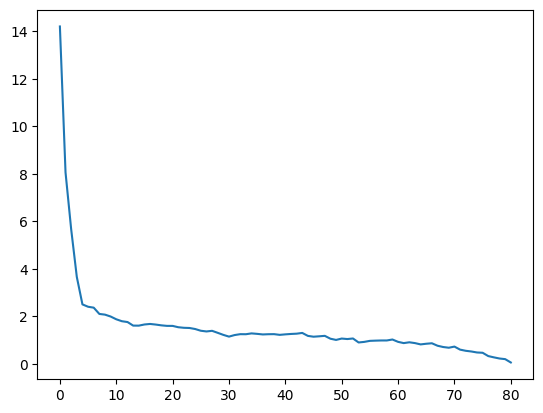

In [5]:
# plot regret
plt.plot([sum(reg[j:]) / (GAMMA ** j) for j in range(DATA_LEN)])

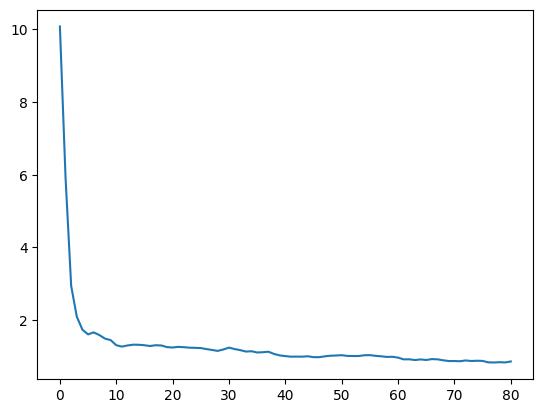

In [6]:
# plot mse
plt.plot(mse)